In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("/Users/giulioelmi/Desktop/kelshi_trading/training_data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1673 entries, 0 to 1672
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   DATE             1673 non-null   object 
 1   TMAX             1673 non-null   int64  
 2   TMIN             1673 non-null   int64  
 3   PRCP             1673 non-null   float64
 4   AWND             1672 non-null   float64
 5   WDF2             1673 non-null   float64
 6   WSF2             1673 non-null   float64
 7   year             1673 non-null   int64  
 8   forecasted_TMAX  1673 non-null   float64
dtypes: float64(5), int64(3), object(1)
memory usage: 117.8+ KB


In [4]:
data["DATE"] = pd.to_datetime(data["DATE"])
data = data.sort_values("DATE")

In [5]:
data["TMAX_next_d"] = data["TMAX"].shift(-1)

In [6]:
data["y"] = data["TMAX_next_d"] - data["forecasted_TMAX"]

<Axes: >

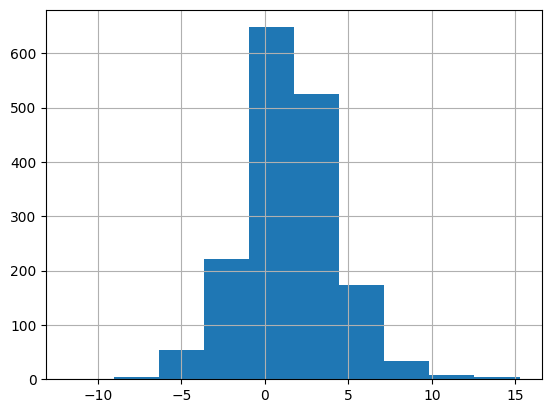

In [7]:
data["y"].hist()

In [8]:
data[data["y"].abs() > 15]

,DATE,TMAX,TMIN,PRCP,AWND,WDF2,WSF2,year,forecasted_TMAX,TMAX_next_d,y
1385,2024-10-17,70,62,0.0,6.49,280.0,15.0,2024,68.756,84.0,15.244


In [9]:
#feature engineering:
import numpy as np
#1. seasonality
data["doy"] = data["DATE"].dt.dayofyear
data["dow"] = data["DATE"].dt.dayofweek
data["month"] = data["DATE"].dt.month
data["doy_sin"] = np.sin(2*np.pi*data["doy"]/365.25)
data["doy_cos"] = np.cos(2*np.pi*data["doy"]/365.25)

In [10]:
#2 derived features
data["diurnal_range"] = data["TMAX"] - data["TMIN"]
data["wind_dir_sin"] = np.sin(np.deg2rad(data["WDF2"]))
data["wind_dir_cos"] = np.cos(np.deg2rad(data["WDF2"]))

In [11]:
#lag columns
lag_cols_1 = ["TMAX", "TMIN", "diurnal_range"]
for c in lag_cols_1:
    for k in [1, 2, 3, 7]:
            data[f"{c}_lag{k}"] = data[c].shift(k)

lag_cols_2 = ["PRCP"]
for k in [1, 2, 3, 4]:
    data[f"PRCP_lag_{k}"] = data["PRCP"].shift(k)

In [12]:
#rolling means
data["rolling_3"] = data["TMAX"].rolling(3).mean()
data["rolling_7"] = data["TMAX"].rolling(7).mean()


In [13]:
full_training_df = data.dropna()

In [14]:
#this is for backtesting. Use the date to divide the data between backtesting and training
print("start: ", full_training_df["DATE"].min())
print("end: ", full_training_df["DATE"].max())

split_date = "2025-03-01 00:00:00"

backtesting_df = full_training_df[full_training_df["DATE"] >=  split_date]

training_df = full_training_df[full_training_df["DATE"] < split_date] 

print("backtesting df start and end: ", backtesting_df["DATE"].min(), "-", backtesting_df["DATE"].max())
print("training df start and end: ", training_df["DATE"].min(), "-", training_df["DATE"].max())


start:  2021-01-08 00:00:00
end:  2025-07-30 00:00:00
backtesting df start and end:  2025-03-01 00:00:00 - 2025-07-30 00:00:00
training df start and end:  2021-01-08 00:00:00 - 2025-02-28 00:00:00


In [15]:
backtesting_df.to_csv("/Users/giulioelmi/Desktop/kelshi_trading/backtesting/backtesting_data.csv")

In [64]:
y = training_df["y"]
X = training_df.drop(columns = ["DATE", "y", "TMAX_next_d"])

In [65]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# X: features (sorted by date), y: target (next-day error)
tscv = TimeSeriesSplit(n_splits=5)

model = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
)

param_dist = {
    "n_estimators": [400, 800, 1200, 2000],
    "learning_rate": [0.01, 0.03, 0.05, 0.08],
    "max_depth": [2, 3, 4, 5, 6],
    "min_child_weight": [1, 3, 5, 8, 12],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [1, 5, 10, 20],
    "reg_alpha": [0.0, 0.01, 0.1],
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    scoring="neg_mean_absolute_error",
    cv=tscv,
    verbose=1,
    random_state=42,
)

search.fit(X, y)

best_model = search.best_estimator_
best_mae = -search.best_score_
best_params = search.best_params_

print("Best MAE:", best_mae)
print("Best params:", search.best_params_)

# Optional: baseline (predict 0 error)
baseline_mae = np.mean(np.abs(y))
print("Baseline MAE (predict 0):", baseline_mae)



Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best MAE: 2.0859804246451397
Best params: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Baseline MAE (predict 0): 2.5405171957671784


In [66]:
directional_accuracy = np.mean(np.sign(best_model.predict(X)) == np.sign(y))
directional_accuracy

0.8287037037037037

In [67]:
best_parameters = best_params

full_model = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="mae",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
    **best_parameters,
)

full_model.fit(X, y)
full_model.save_model("/Users/giulioelmi/Desktop/kelshi_trading/backtesting/best_backtesting.json")


In [68]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor

def compute_oof_residuals(
    X, y, dates, best_params,
    min_train_size=365,
    step=30,
):
    """
    Expanding-window walk-forward.
    Returns OOF predictions and residuals.
    """

    X = X.reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)
    dates = pd.to_datetime(dates).reset_index(drop=True)

    n = len(X)
    oof_pred = np.full(n, np.nan)

    train_end = min_train_size
    while train_end < n:
        test_end = min(train_end + step, n)

        X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
        X_test = X.iloc[train_end:test_end]

        model = XGBRegressor(
            objective="reg:squarederror",
            eval_metric="mae",
            tree_method="hist",
            n_jobs=-1,
            random_state=42,
            **best_params,
        )

        model.fit(X_train, y_train)
        oof_pred[train_end:test_end] = model.predict(X_test)

        train_end = test_end

    mask = ~np.isnan(oof_pred)
    residuals = y[mask].values - oof_pred[mask]

    return residuals, oof_pred


In [69]:
dates = training_df["DATE"]
residuals, oof_pred = compute_oof_residuals(
    X,
    y,
    dates,
    best_parameters,
)

sigma = np.std(residuals, ddof=1)
print("Out-of-sample σ:", sigma)


Out-of-sample σ: 2.614391493712777
